In [1]:
!pip install --upgrade openpifpaf==0.10.1

In [2]:
import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

print(openpifpaf.__version__)
print(torch.__version__)

0.10.1
1.13.1+cpu


In [6]:
import os
from PIL import Image
import numpy as np
from tkinter import Tk, filedialog

# Create a Tkinter root window
root = Tk()
root.withdraw()

# Open a file dialog to select the image files
uploaded_files = filedialog.askopenfilenames()

# Create a list to store the PIL images
pil_images = []

# Create an empty list to store the image names
image_names = []

# Iterate over the selected file paths
for file_path in uploaded_files:
    # Open and process each image
    pil_im = Image.open(file_path).convert('RGB')
    pil_images.append(pil_im)  # Append the PIL image to the list

    width, height = pil_im.size

    im = np.asarray(pil_im)
    print(f"Image: {file_path}")
    print(f"Width: {width}, Height: {height}")

    # Extract the image name from the file path
    image_name = os.path.basename(file_path)
    image_names.append(image_name)  # Append the image name to the list

# Now you have all the uploaded images stored in the 'pil_images' list for further processing
# and the corresponding image names in the 'image_names' list


Image: C:/Users/99291/Desktop/lab_work/3 test folders/161241_output/161241_000000.475.png
Width: 1920, Height: 1080


In [4]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')
# net = net_cpu.cuda()

net = net_cpu

C:\Users\99291\Desktop\pythonProject\venv\lib\site-packages\torch\serialization.py:868: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\99291\Desktop\pythonProject\venv\lib\site-packages\torch\serialization.py:868: SourceChangeWarning: source code of class 'openpifpaf.network.basenetworks.BaseNetwork' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\99291\Desktop\pythonProject\venv\lib\site-packages\torch\serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve 

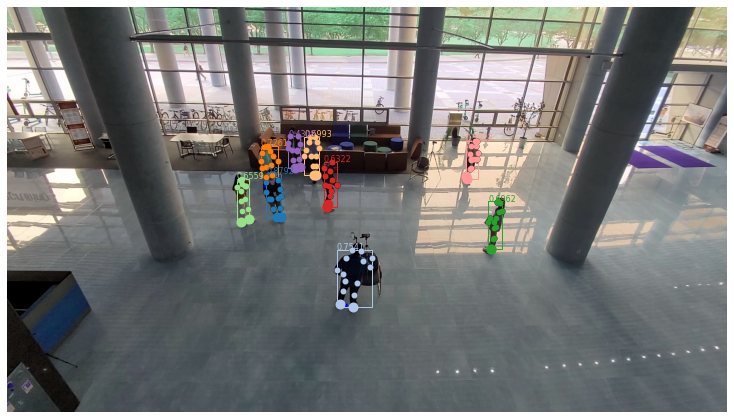

In [7]:
from matplotlib.pyplot import colormaps
from matplotlib import colors
import torch
import openpifpaf

# Assuming you have a list of PIL images named 'pil_images'
coordinates_list = []

# Initialize the network
net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')
# net = net_cpu.cuda()
net  = net_cpu

# Initialize the decoder
decode = openpifpaf.decoder.factory_decode(net, seed_threshold=0.5)

# Initialize the processor with the network and decoder
processor = openpifpaf.decoder.Processor(net, decode, instance_threshold=0.2, keypoint_threshold=0.2)

for pil_im in pil_images:
    # Convert the PIL image to a tensor dataset
    data = openpifpaf.datasets.PilImageList([pil_im])
    loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

    # Create the keypoint painter for visualizations
    keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=False, linewidth=0.02,
                                                       highlight=[15, 16], solid_threshold=0.01,
                                                       highlight_invisible=True, markersize=4)

    keypoint_painter.show_box = True
    keypoint_painter.xy_scale = 1.0

    # Process the image and obtain predictions
    for images_batch, _, __ in loader:
        images_batch = images_batch
        fields_batch = processor.fields(images_batch)
        predictions = processor.annotations(fields_batch[0])

        # Visualize the image with annotations
        with openpifpaf.show.image_canvas(pil_im) as ax:
            keypoint_painter.annotations(ax, predictions)

        # Extract coordinates
        coordinates = []
        for i, pred in enumerate(predictions):
            x = 0
            y = 0
            left_ankle_x, left_ankle_y, _ = pred.data[16]
            right_ankle_x, right_ankle_y, _ = pred.data[15]
            left_hip_x, left_hip_y, _ = pred.data[11]
            right_hip_x, right_hip_y, _ = pred.data[8]

            # If both ankles are invisible, calculate the hip coordinates
            if left_ankle_x == 0 and right_ankle_x == 0:
                left_hip_x, left_hip_y, _ = pred.data[11]
                right_hip_x, right_hip_y, _ = pred.data[8]

                if left_hip_x != 0 and right_hip_x != 0:
                    x = int((left_hip_x + right_hip_x) / 2)
                    # x = int((left_hip_x + right_hip_x) / 2) + 70
                    y = int((left_hip_y + right_hip_y) / 2)+60
                elif left_hip_x == 0 or right_hip_x == 0:
                    x = int(left_hip_x+right_hip_x)
                    # x = int(left_hip_x+right_hip_x) + 70
                    y = int(left_hip_y+right_hip_y)+60
                    # x = int(right_hip_x) + 70
                    # y = int(right_hip_y)
                else:
                     continue  # Skip this instance if both hips are not visible
            # If only one ankle is invisible, use the visible ankle coordinate
            elif left_ankle_x == 0 or right_ankle_x == 0:
                x = int(right_ankle_x+left_ankle_x)
                y = int(right_ankle_y+left_ankle_y)
             # elif right_ankle_x == 0:
            #     x = int(left_ankle_x)
            #     y = int(left_ankle_y)
            # If both ankles are visible, calculate the midpoint between them
            else:
                x = int((left_ankle_x + right_ankle_x) / 2)
                y = int((left_ankle_y + right_ankle_y) / 2)

            if x != 0 and y != 0:
                coordinates.append((x, y))

        # Add the coordinates to the list
        coordinates_list.append(coordinates)


# Specify the file path for the output .txt file
output_file_path = "C:/Users/99291/Desktop/161241_output/161241_output_coordinates.txt"

# Open the file in write mode
with open(output_file_path, "w") as file:
    # Iterate over the images and their coordinates
    for i in range(len(pil_images)):
        # Get the image name
        image_name = image_names[i]  # Modify the slicing to limit the length of the image name if desired

        # Get the coordinates for the current image
        coordinates = coordinates_list[i]

        # Write the image name to the file
        file.write(f"['{image_name}']: [\n")

        # Write the coordinates to the file
        for cord in coordinates:
            file.write(f"[{cord[0]}, {cord[1]}],\n")

        file.write('],\n')



In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the size of the highlight
radius = 5

# Define the color of the highlight
color = (255, 0, 0)  # Blue

output_directory = "C:/Users/99291/Desktop/161241_output"
os.makedirs(output_directory, exist_ok=True)

# Iterate over the images and their coordinates
for i in range(len(pil_images)):
    # Load the image
    image = pil_images[i]
    image_name = image_names[i]
    # Convert the image to a numpy array
    img = np.array(image)

    # Get the coordinates for the current image
    coordinates = coordinates_list[i]

    # Draw circles for each coordinate
    for cord in coordinates:
        # Draw a circle at the specified pixel
        cv2.circle(img, cord, radius, color, -1)

    print(f"'{image_name}'")
    output_file_name = image_name
    output_file = os.path.join(output_directory, output_file_name)
    # plt.savefig(output_file, bbox_inches='tight', pad_inches=0, transparent=True)

    # Display the image with highlighted coordinates
    # cv2.imshow("Image with Highlights", img)
    cv2.imwrite(output_file, img)

# Wait for any key press and then close the windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()


'161241_000000.475.png'
'161241_000000.804.png'
'161241_000001.142.png'
'161241_000001.472.png'
'161241_000001.807.png'
'161241_000002.137.png'
'161241_000002.473.png'
'161241_000002.801.png'
'161241_000003.134.png'
'161241_000003.467.png'
'161241_000003.802.png'
'161241_000004.134.png'
'161241_000004.467.png'
'161241_000004.802.png'
'161241_000005.133.png'
'161241_000005.469.png'
'161241_000005.801.png'
'161241_000006.134.png'
'161241_000006.467.png'
'161241_000006.799.png'
'161241_000007.132.png'
'161241_000007.467.png'
'161241_000007.800.png'
'161241_000008.133.png'
'161241_000008.467.png'
'161241_000008.801.png'
'161241_000009.133.png'
'161241_000009.466.png'
'161241_000009.801.png'
'161241_000010.133.png'
'161241_000010.467.png'
'161241_000010.799.png'
'161241_000011.132.png'
'161241_000011.465.png'
'161241_000011.800.png'
'161241_000012.132.png'
'161241_000012.466.png'
'161241_000012.800.png'
'161241_000013.134.png'
'161241_000013.466.png'
'161241_000013.800.png'
'161241_000014.1